# Temperature dependent elastic constants

## Background

$$C_{ijkl} = \frac{1}{V} \frac{\partial^2 U}{\partial \varepsilon_{ij}\partial \varepsilon_{kl}}$$

$$U(T) = \frac{V}{2}C_{ijkl}(T)\varepsilon_{ij}\varepsilon_{kl}$$

$$\sigma_{ij} = C_{ijkl}{\varepsilon_{kl}}$$

### How to get $U$ or $\sigma$

- MD
- Quasi-Harmonic

## Tasks

- Get $a_0$ from potential
- Lattice parameter (as a function of T)
  - MD
    - NVT
    - NPT
  - QH
- Calculate $U$ or $\sigma$ for various $\varepsilon$
  - MD: Equilibriate and average with LAMMPS
  - QH: Get strains from Yuriy's tool and run phonopy
- Fit

## Teams

- MD: Erik, Han, (Raynol), Prabhath, Jan, Sriram
- QH: Raynol, (Sam), Bharathi, Ahmed, Haitham
- Fit & Yuriy: Sam
- Literature

# Implementation

* https://atomistics.readthedocs.io/en/latest/bulk_modulus_with_gpaw.html#elastic-matrix
* https://github.com/pyiron/atomistics/blob/main/tests/test_elastic_lammpslib_functional.py
* https://github.com/pyiron/pyiron_workflow_atomistics/blob/interstitials/pyiron_workflow_atomistics/dataclass_storage.py
* https://github.com/ligerzero-ai/pyiron_workflow_lammps/blob/main/pyiron_workflow_lammps/engine.py#L21

## Reference

We compare our values with the paper - [M. Krief, et. al., Physical Review E, 103, 063307, 2021](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.103.063307#s4)

Potential used: Copper [Mishin potential](https://www.ctcms.nist.gov/potentials/entry/2001--Mishin-Y-Mehl-M-J-Papaconstantopoulos-D-A-et-al--Cu-1/)

## Imports

In [1]:
from ase.build import bulk
from ase.atoms import Atoms

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from __future__ import annotations

from atomistics.workflows.elastic.workflow import (
    get_tasks_for_elastic_matrix,
    analyse_results_for_elastic_matrix
)

from atomistics.calculators import (
    evaluate_with_lammpslib, 
    get_potential_by_name, 
    calc_molecular_dynamics_npt_with_lammpslib, 
    calc_molecular_dynamics_nvt_with_lammpslib
)

from atomistics.calculators.lammps.libcalculator import (
    calc_static_with_lammpslib, 
    calc_molecular_dynamics_langevin_with_lammpslib
)

/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.12/site-packages/atomistics/calculators/__init__.py:63: UserWarning: calc_static_with_qe(), evaluate_with_qe() and optimize_positions_and_volume_with_qe() are not available as the import of the module named 'pwtools' failed.
  raise_warning(module_list=quantum_espresso_function, import_error=e)


In [3]:
from pyiron_base import Project, job

In [4]:
pr = Project("Convergence_Studies_MD_Elastic_Constants")

## Create bulk sample with a guessed lattice constant

In [5]:
unit_cell = bulk('Cu', 'fcc', a=3.6514, cubic=True) # 4 atoms

In [6]:
repeated_unit_cell = unit_cell.repeat(5) # 500 atoms

In [7]:
potential_name_str = "2001--Mishin-Y--Cu-1--LAMMPS--ipr1"

potential_df = get_potential_by_name(
    potential_name=potential_name_str
)

## 0K Relaxed Structure

In [8]:
def get_relaxed_structure_at_0K(
        structure: Atoms, 
        potential: str, 
        lmp_optimizer_kwargs : dict = None
        ) -> Atoms:
    
    df_pot_selected = get_potential_by_name(
        potential_name=potential
        )
    
    result_dict = evaluate_with_lammpslib(
        task_dict={"optimize_positions_and_volume": structure},
        potential_dataframe=df_pot_selected,
        lmp_optimizer_kwargs=lmp_optimizer_kwargs
        )
    
    structure_relaxed = result_dict['structure_with_optimized_positions_and_volume']

    return structure_relaxed

In [9]:
lmp_optimizer_kwargs={
    'min_style':'cg',
    'ionic_force_tolerance':1e-8,
    'pressure':np.zeros(6) # add anisotropy
}

In [10]:
relaxed_unit_cell = get_relaxed_structure_at_0K(
    unit_cell, # 4 atoms
    potential_name_str, 
    lmp_optimizer_kwargs
)

relaxed_unit_cell # 4 atoms

Atoms(symbols='Cu4', pbc=True, cell=[3.61500008107858, 3.61500008107858, 3.6150000810785805])

## 0K Lattice Constant

In [11]:
def get_lattice_constant_at_0K(
        structure: Atoms, 
        potential: str, 
        lmp_optimizer_kwargs : dict = None
        ) -> float:

    structure_relaxed = get_relaxed_structure_at_0K(
        structure=structure, 
        potential=potential,
        lmp_optimizer_kwargs=lmp_optimizer_kwargs
    )
    
    a_0 = structure_relaxed.get_volume()**(1/3)

    return a_0 # Angstrom

In [12]:
a_0 = get_lattice_constant_at_0K(
    structure=unit_cell, 
    potential=potential_name_str,
    lmp_optimizer_kwargs=lmp_optimizer_kwargs)

a_0 # Angstrom

np.float64(3.61500008107858)

We get the same lattice constant at 0K as the reference paper!

## 0K Elastic Constants

In [13]:
def get_strain_tensor_cubic(
        structure : Atoms, 
        strain : float = 0.005
    ) -> dict:

    deformation_gradient_dict = {
        'C11': np.eye(3,3) + np.array([[ strain,      0,      0], 
                                       [      0,      0,      0],
                                       [      0,      0,      0]]),
        'C12': np.eye(3,3) + np.array([[ strain,      0,      0], 
                                       [      0, strain,      0], 
                                       [      0,      0,      0]]),
        'C44': np.eye(3,3) + np.array([[      0,      0,      0], 
                                       [      0,      0, strain], 
                                       [      0, strain,      0]])
    }

    return deformation_gradient_dict

In [14]:
def get_elastic_constants_from_stress_tensor(
        tensor_dict : dict, 
        strain : float
    ) -> list[float]:

    elastic_constants_list = []

    for constant_str, diff in tensor_dict.items():
        if constant_str == 'C11':
            constant = diff[0, 0] / strain
            elastic_constants_list.append(abs(constant))

        elif constant_str == 'C12':
            sigma33 = diff[2, 2]
            constant = (sigma33/ strain) / 2
            elastic_constants_list.append(abs(constant))

        elif constant_str == 'C44':
            sigma23 = diff[2, 1]
            constant = sigma23 / (2 * strain)
            elastic_constants_list.append(abs(constant))

    return elastic_constants_list

In [15]:
def get_stress_tensor_at_0K(
        structure : Atoms, 
        potential_dataframe : pd.DataFrame, 
        deformation_gradient : np.array
    ):
    
    structure_strained = structure.copy()
    relaxed_cell = np.array(structure_strained.get_cell().tolist())

    strained_cell = deformation_gradient@relaxed_cell
    structure_strained.set_cell(
        strained_cell, 
        scale_atoms=True
    )
    
    relaxed_dict = calc_static_with_lammpslib(
        structure=structure, 
        potential_dataframe=potential_dataframe
    )
    strained_dict = calc_static_with_lammpslib(
        structure=structure_strained,
        potential_dataframe=potential_dataframe
    )

    relaxed_dict['stress_GPa'] = relaxed_dict['stress'] / 10**4
    strained_dict['stress_GPa'] = strained_dict['stress'] / 10**4

    stress_diff = strained_dict['stress_GPa'] - relaxed_dict['stress_GPa']
    
    return stress_diff, relaxed_dict, strained_dict

In [16]:
def calculate_elastic_constants_at_0K(
        structure : Atoms, 
        potential_name : str,
        strain : float = 0.005
    ):

    df_pot_selected = get_potential_by_name(
        potential_name=potential_name
    )

    deformation_gradient_dict = get_strain_tensor_cubic(
        structure=structure, 
        strain=strain
    )
    
    tensor_dict = {}
    for constant_str, deformation_gradient in deformation_gradient_dict.items():
        diff, relaxed_dict, strained_dict = get_stress_tensor_at_0K(
            structure=structure,
            potential_dataframe=df_pot_selected,
            deformation_gradient=deformation_gradient
        )
        
        tensor_dict[constant_str] = diff
        tensor_dict[f'relaxed_dict_{constant_str}'] = relaxed_dict
        tensor_dict[f'strained_dict_{constant_str}'] = strained_dict
    
    elastic_constants_list = get_elastic_constants_from_stress_tensor(
        tensor_dict=tensor_dict, 
        strain=strain
    )

    return elastic_constants_list, tensor_dict

## Reference function to fit elastic constants (Jan + Yury)'s

Requires only `relaxed_unit_cell` and `potential_name_str` from previous cells

In [17]:
def fit_elastic_constants(
        structure: Atoms, 
        potential: str, 
        strains, 
        stresses=None, 
        energies=None):

    task_dict, sym_dict = get_tasks_for_elastic_matrix(
        structure=structure,
        eps_range=0.005,
        num_of_point=5,
        zero_strain_job_name="s_e_0",
        sqrt_eta=True
    )

    potential_df = get_potential_by_name(
        potential_name=potential
    )

    result_dict = evaluate_with_lammpslib(
        task_dict=task_dict,
        potential_dataframe=potential_df,
    )
    
    elastic_dict, sym_dict = analyse_results_for_elastic_matrix(
        output_dict=result_dict,
        sym_dict=sym_dict,
        fit_order=2,
        zero_strain_job_name="s_e_0",
    )

    return elastic_dict

In [18]:
elastic_dict = fit_elastic_constants(
    structure=relaxed_unit_cell,
    potential=potential_name_str,
    strains=None
)

In [19]:
elastic_dict['elastic_matrix']

array([[169.74837327, 123.55258251, 123.55258251,   0.        ,
          0.        ,   0.        ],
       [123.55258251, 169.74837327, 123.55258251,   0.        ,
          0.        ,   0.        ],
       [123.55258251, 123.55258251, 169.74837327,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,  76.24914297,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
         76.24914297,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,  76.24914297]])

In [20]:
elastic_constants_list_reference = [
    elastic_dict['elastic_matrix'][0,0], 
    elastic_dict['elastic_matrix'][0,1], 
    elastic_dict['elastic_matrix'][3,3]
    ]

np.round(elastic_constants_list_reference, 1) # GPa

array([169.7, 123.6,  76.2])

In comparison with the [reference paper](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.103.063307#s4 "M. Krief, et. al., Physical Review E, 103, 063307, 2021"),

$C_{11}$=169.9GPa, $C_{12}$=122.6GPa, and $C_{44}$=76.2GPa

## Finite Temperature equlibiration
* First run NPT to relax volume
* Then equilibriate the cell by running NVT

In [21]:
def equilibriate_structure_at_finite_temperature(
        structure : Atoms, 
        potential : str, 
        temperature : float = 500,
        run : int = 100000,
        thermo : int = 100,
        seed : int = 4928459, 
        cell_scale_value : int = 5,
        thermostat : str = 'langevin'
    ) -> Atoms:

    df_pot_selected = get_potential_by_name(
        potential_name=potential
    )
    
    structure_repeated = structure.repeat(cell_scale_value)

    npt_dict = calc_molecular_dynamics_npt_with_lammpslib(
        structure=structure_repeated,
        potential_dataframe=df_pot_selected,
        Tstart=temperature,
        Tstop=temperature,
        run=run,
        thermo=thermo,
        seed=seed
    )
    
    npt_lattice_constant = (np.mean(npt_dict['volume'][20:]/len(structure_repeated))*len(structure))**(1/3)
    
    # FIXME: Make it for a generic element - something might be wrong here. Need to check error propagation
    # structure_npt = bulk('Cu', a=npt_lattice_constant, cubic=True)
    # structure_repeated_npt = structure_npt.repeat(cell_scale_value)
    
    structure_repeated_npt = structure.copy()
    structure_repeated_npt.set_cell(
        [[npt_lattice_constant,0,0], 
         [0,npt_lattice_constant,0], 
         [0,0,npt_lattice_constant]],
        scale_atoms = True
    )
    structure_repeated_npt = structure_repeated_npt.repeat(cell_scale_value)

    if thermostat == 'nose-hoover':
        nvt_dict = calc_molecular_dynamics_nvt_with_lammpslib(
            structure=structure_repeated_npt,
            potential_dataframe=df_pot_selected,
            Tstart=temperature,
            Tstop=temperature,
            run=run,
            thermo=thermo,
            seed=seed
        )
        
    elif thermostat == 'langevin':
        nvt_dict = calc_molecular_dynamics_langevin_with_lammpslib(
            structure=structure_repeated_npt,
            potential_dataframe=df_pot_selected,
            Tstart=temperature,
            Tstop=temperature,
            run=run,
            thermo=thermo,
            seed=seed
        )
        
    structure_repeated_nvt = structure_repeated_npt.copy()
    structure_repeated_nvt.set_cell(
        nvt_dict['cell'][-1]
    )
    structure_repeated_nvt.set_positions(
        nvt_dict['positions'][-1]
    )
    structure_repeated_nvt.set_velocities(
        nvt_dict['velocities'][-1]
    )

    return structure_repeated_nvt

## Temperature-dependent Elastic Constants

In [22]:
def get_stress_tensor_at_finite_temperature(
        structure : Atoms, 
        potential_dataframe : pd.DataFrame, 
        deformation_gradient : np.array, 
        temperature : float,
        run : int, 
        thermo : int,
        seed : int,
        thermostat : str
    ):
    
    structure_strained = structure.copy()
    relaxed_cell = np.array(structure_strained.get_cell().tolist())

    strained_cell = deformation_gradient@relaxed_cell
    structure_strained.set_cell(
        strained_cell, 
        scale_atoms=True
    )
    
    if thermostat == 'nose-hoover':
        relaxed_dict = calc_molecular_dynamics_nvt_with_lammpslib(
            structure=structure, 
            potential_dataframe=potential_dataframe,
            Tstart=temperature,
            Tstop=temperature,
            run=run,
            thermo=thermo,
            seed=seed,
            disable_initial_velocity=True
        )
        strained_dict = calc_molecular_dynamics_nvt_with_lammpslib(
            structure=structure_strained, 
            potential_dataframe=potential_dataframe,
            Tstart=temperature,
            Tstop=temperature,
            run=run,
            thermo=thermo,
            seed=seed,
            disable_initial_velocity=True
        )
    
    elif thermostat == 'langevin':
        relaxed_dict = calc_molecular_dynamics_langevin_with_lammpslib(
            structure=structure, 
            potential_dataframe=potential_dataframe,
            Tstart=temperature,
            Tstop=temperature,
            run=run,
            thermo=thermo,
            seed=seed,
            disable_initial_velocity=True
        )
        strained_dict = calc_molecular_dynamics_langevin_with_lammpslib(
            structure=structure_strained, 
            potential_dataframe=potential_dataframe,
            Tstart=temperature,
            Tstop=temperature,
            run=run,
            thermo=thermo,
            seed=seed,
            disable_initial_velocity=True
        )

    relaxed_dict['pressure_GPa'] = relaxed_dict['pressure'] / 10**4
    strained_dict['pressure_GPa'] = strained_dict['pressure'] / 10**4

    stress_diff = -np.mean(strained_dict['pressure_GPa'][20:] - relaxed_dict['pressure_GPa'][20:], axis=0)

    return stress_diff, relaxed_dict, strained_dict

Implement [Mean Measure value](https://github.com/pyiron/pyiron_atomistics/blob/c469a6ecbb787291dcc957f348cf74446fdc7ddc/pyiron_atomistics/lammps/control.py#L704) from pyiron_atomistics maybe?

In [23]:
def calculate_elastic_constants_at_finite_temperature(
        structure : Atoms, # change to unit cell
        cell_scale_value : int,
        potential_name : str, 
        temperature : float = 0, 
        strain : float = 0.005,
        run : int = 10000,
        thermo : int = 100, 
        seed : int = 42, 
        thermostat : str = 'langevin'
    ):

    df_pot_selected = get_potential_by_name(
        potential_name=potential_name
    )

    equilibriated_structure = equilibriate_structure_at_finite_temperature(
        structure=structure,
        potential=potential_name_str, 
        temperature=temperature, 
        seed=seed,
        cell_scale_value=cell_scale_value
    )
    
    deformation_gradient_dict = get_strain_tensor_cubic(
        structure=equilibriated_structure, 
        strain=strain
    )
    
    tensor_dict = {}
    for constant_str, deformation_gradient in deformation_gradient_dict.items():
        diff, relaxed_dict, strained_dict = get_stress_tensor_at_finite_temperature(
            structure=equilibriated_structure, 
            potential_dataframe=df_pot_selected,
            deformation_gradient=deformation_gradient,
            temperature=temperature,
            run=run,
            thermo=thermo,
            seed=seed,
            thermostat=thermostat
        )
        
        tensor_dict[constant_str] = diff
        tensor_dict[f'relaxed_dict_{constant_str}'] = relaxed_dict
        tensor_dict[f'strained_dict_{constant_str}'] = strained_dict
    
    elastic_constants_list = get_elastic_constants_from_stress_tensor(
        tensor_dict=tensor_dict, 
        strain=strain
    )

    return {"elastic_constants": elastic_constants_list, "tensor_dict": tensor_dict}

# Convergence studies

In [24]:
input_params_scale = {
    "cell_scale_value" : [3, 5, 7, 9],
    "run" : [5000, 10000, 20000, 30000, 40000, 50000],
    "temperature" : [500],
    "strain" : [0.005],
    "seed": [1357],
    "thermostat" : ["langevin"]
}

In [25]:
from itertools import product
keys = input_params_scale.keys()
values = input_params_scale.values()

for combo in product(*values):
    params = dict(zip(keys, combo))
    print(params)

{'cell_scale_value': 3, 'run': 5000, 'temperature': 500, 'strain': 0.005, 'seed': 1357, 'thermostat': 'langevin'}
{'cell_scale_value': 3, 'run': 10000, 'temperature': 500, 'strain': 0.005, 'seed': 1357, 'thermostat': 'langevin'}
{'cell_scale_value': 3, 'run': 20000, 'temperature': 500, 'strain': 0.005, 'seed': 1357, 'thermostat': 'langevin'}
{'cell_scale_value': 3, 'run': 30000, 'temperature': 500, 'strain': 0.005, 'seed': 1357, 'thermostat': 'langevin'}
{'cell_scale_value': 3, 'run': 40000, 'temperature': 500, 'strain': 0.005, 'seed': 1357, 'thermostat': 'langevin'}
{'cell_scale_value': 3, 'run': 50000, 'temperature': 500, 'strain': 0.005, 'seed': 1357, 'thermostat': 'langevin'}
{'cell_scale_value': 5, 'run': 5000, 'temperature': 500, 'strain': 0.005, 'seed': 1357, 'thermostat': 'langevin'}
{'cell_scale_value': 5, 'run': 10000, 'temperature': 500, 'strain': 0.005, 'seed': 1357, 'thermostat': 'langevin'}
{'cell_scale_value': 5, 'run': 20000, 'temperature': 500, 'strain': 0.005, 'seed':

In [26]:
def calculate_elastic_constants_for_different_temperatures(
        structure: Atoms, 
        potential_name_str: str, 
        input_params: dict, 
        project: Project):

    from itertools import product
    from pyiron_base import job
    
    keys = input_params.keys()
    values = input_params.values()

    for combo in product(*values):
        params = dict(zip(keys, combo))

        try:
            conv_job = job(calculate_elastic_constants_at_finite_temperature)
            conv_out = conv_job(
                structure = structure,
                potential_name = potential_name_str,
                pyiron_project = project,
                **params
            )

            conv_out.server.queue = "cmmg"
            conv_out.server.cores = 1
            conv_out.server.run_time = 18000

            conv_future = conv_out.pull()

        except:
            continue

In [27]:
calculate_elastic_constants_for_different_temperatures(
    structure=relaxed_unit_cell,
    potential_name_str=potential_name_str,
    input_params = input_params_scale,
    project = pr
)

The job calculate_elastic_constants_at_finite_temperature_72ff066aa993f4453687b0734f383adf was saved and received the ID: 30482531
Queue system id:  18743929
The job calculate_elastic_constants_at_finite_temperature_df74203a63d29e428c2fafa2bf6886cc was saved and received the ID: 30482532
Queue system id:  18743930
The job calculate_elastic_constants_at_finite_temperature_4eb5155d0b575e0d96a5f28ab15d7c76 was saved and received the ID: 30482533
Queue system id:  18743931
The job calculate_elastic_constants_at_finite_temperature_21e3030ff212e788df4ef87c8665f1e5 was saved and received the ID: 30482534
Queue system id:  18743932
The job calculate_elastic_constants_at_finite_temperature_c5fc7f7177992b98730e8a4b7f8f27c3 was saved and received the ID: 30482535
Queue system id:  18743933
The job calculate_elastic_constants_at_finite_temperature_c6126b1dd976089e04a37ad0b78a09cd was saved and received the ID: 30482536
Queue system id:  18743934
The job calculate_elastic_constants_at_finite_temper

In [27]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
10,30482531,finished,None,calculate_elastic_constants_at_finite_temperature_72ff066aa993f4453687b0734f383adf,/calculate_elastic_constants_at_finite_temperature_72ff066aa993f4453687b0734f383adf,/cmmc/u/,pchilaka/1_Work/1_My_Notebooks/5_Hackathons/hackathon/hackathon/elastic_constants/MD/Convergence_Studies_MD_Elastic_Constants/,2025-11-12 16:30:35.031432,None,None,pchilaka@cmti001#1#cmmg,PythonFunctionContainerJob,0.4,None,None
11,30482532,finished,None,calculate_elastic_constants_at_finite_temperature_df74203a63d29e428c2fafa2bf6886cc,/calculate_elastic_constants_at_finite_temperature_df74203a63d29e428c2fafa2bf6886cc,/cmmc/u/,pchilaka/1_Work/1_My_Notebooks/5_Hackathons/hackathon/hackathon/elastic_constants/MD/Convergence_Studies_MD_Elastic_Constants/,2025-11-12 16:30:35.255590,None,None,pchilaka@cmti001#1#cmmg,PythonFunctionContainerJob,0.4,None,None
0,30482533,finished,None,calculate_elastic_constants_at_finite_temperature_4eb5155d0b575e0d96a5f28ab15d7c76,/calculate_elastic_constants_at_finite_temperature_4eb5155d0b575e0d96a5f28ab15d7c76,/cmmc/u/,pchilaka/1_Work/1_My_Notebooks/5_Hackathons/hackathon/hackathon/elastic_constants/MD/Convergence_Studies_MD_Elastic_Constants/,2025-11-12 16:30:35.417709,None,None,pchilaka@cmti001#1#cmmg,PythonFunctionContainerJob,0.4,None,None
1,30482534,finished,None,calculate_elastic_constants_at_finite_temperature_21e3030ff212e788df4ef87c8665f1e5,/calculate_elastic_constants_at_finite_temperature_21e3030ff212e788df4ef87c8665f1e5,/cmmc/u/,pchilaka/1_Work/1_My_Notebooks/5_Hackathons/hackathon/hackathon/elastic_constants/MD/Convergence_Studies_MD_Elastic_Constants/,2025-11-12 16:30:35.593344,None,None,pchilaka@cmti001#1#cmmg,PythonFunctionContainerJob,0.4,None,None
3,30482535,finished,None,calculate_elastic_constants_at_finite_temperature_c5fc7f7177992b98730e8a4b7f8f27c3,/calculate_elastic_constants_at_finite_temperature_c5fc7f7177992b98730e8a4b7f8f27c3,/cmmc/u/,pchilaka/1_Work/1_My_Notebooks/5_Hackathons/hackathon/hackathon/elastic_constants/MD/Convergence_Studies_MD_Elastic_Constants/,2025-11-12 16:30:35.754474,None,None,pchilaka@cmti001#1#cmmg,PythonFunctionContainerJob,0.4,None,None
5,30482536,finished,None,calculate_elastic_constants_at_finite_temperature_c6126b1dd976089e04a37ad0b78a09cd,/calculate_elastic_constants_at_finite_temperature_c6126b1dd976089e04a37ad0b78a09cd,/cmmc/u/,pchilaka/1_Work/1_My_Notebooks/5_Hackathons/hackathon/hackathon/elastic_constants/MD/Convergence_Studies_MD_Elastic_Constants/,2025-11-12 16:30:35.920647,None,None,pchilaka@cmti001#1#cmmg,PythonFunctionContainerJob,0.4,None,None
6,30482537,finished,None,calculate_elastic_constants_at_finite_temperature_f2e5ccf86e25a6d725d2c64daf1ac670,/calculate_elastic_constants_at_finite_temperature_f2e5ccf86e25a6d725d2c64daf1ac670,/cmmc/u/,pchilaka/1_Work/1_My_Notebooks/5_Hackathons/hackathon/hackathon/elastic_constants/MD/Convergence_Studies_MD_Elastic_Constants/,2025-11-12 16:30:36.078920,None,None,pchilaka@cmti001#1#cmmg,PythonFunctionContainerJob,0.4,None,None
2,30482538,finished,None,calculate_elastic_constants_at_finite_temperature_640b524d9b31b47f34566ac8eb65b6b7,/calculate_elastic_constants_at_finite_temperature_640b524d9b31b47f34566ac8eb65b6b7,/cmmc/u/,pchilaka/1_Work/1_My_Notebooks/5_Hackathons/hackathon/hackathon/elastic_constants/MD/Convergence_Studies_MD_Elastic_Constants/,2025-11-12 16:30:36.234573,None,None,pchilaka@cmti001#1#cmmg,PythonFunctionContainerJob,0.4,None,None
7,30482539,finished,None,calculate_elastic_constants_at_finite_temperature_f66b8a39fde3eeec3f0f41a5e030df3a,/calculate_elastic_constants_at_finite_temperature_f66b8a39fde3eeec3f0f41a5e030df3a,/cmmc/u/,pchilaka/1_Work/1_My_Notebooks/5_Hackathons/hackathon/hackathon/elastic_constants/MD/Convergence_Studies_MD_Elastic_Constants/,2025-11-12 16:30:36.397845,None,None,pchilaka@cmti001#1#cmmg,PythonFunctionContainerJob,0.4,N

## Pyiron table

In [28]:
def db_filter_function(job_table):
    return (job_table.status == "finished") & (job_table.hamilton == "PythonFunctionContainerJob")

def job_filter_function(job):
    return (job.status == "finished") & ("calculate" in job.name)

def get_input_structure(job):
    return job.project_hdf5['input']['data']['structure']

def get_natoms_input(job):
    return len(get_input_structure(job))

def get_cell_scale_value(job):
    return job.project_hdf5['input']['data']['cell_scale_value']

def get_natoms_output(job):
    cell_scale_value = get_cell_scale_value(job)
    n_atoms_unit_cell = len(get_input_structure(job))
    return (cell_scale_value ** 3) * n_atoms_unit_cell

def get_potential_name(job):
    return job.project_hdf5['input']['data']['potential_name']

def get_temperature(job):
    return job.project_hdf5['input']['data']['temperature']

def get_strain(job):
    return job.project_hdf5['input']['data']['strain']

def get_run(job):
    return job.project_hdf5['input']['data']['run']

def get_thermo(job):
    return job.project_hdf5['input']['data']['thermo']

def get_seed(job):
    return job.project_hdf5['input']['data']['seed']

def get_thermostat(job):
    return job.project_hdf5['input']['data']['thermostat']

def get_C11(job):
    return job.project_hdf5['storage']['output__index_1']['result__index_0']['elastic_constants'][0]

def get_C12(job):
    return job.project_hdf5['storage']['output__index_1']['result__index_0']['elastic_constants'][1]

def get_C44(job):
    return job.project_hdf5['storage']['output__index_1']['result__index_0']['elastic_constants'][2]

In [29]:
table = pr.create.table("Convergence_pyiron_table", delete_existing_job=True)

# table.db_filter_function = db_filter_function
table.filter_function = job_filter_function

table.add["input_structure"] = get_input_structure
table.add["natoms_input"] = get_natoms_input
table.add["cell_scale_value"] = get_cell_scale_value
table.add["natoms_output"] = get_natoms_output
table.add["potential_name"] = get_potential_name
table.add["temperature"] = get_temperature
table.add["strain"] = get_strain
table.add["run"] = get_run
table.add["thermo"] = get_thermo
table.add["seed"] = get_seed
table.add["thermostat"] = get_thermostat

table.add["C11"] = get_C11
table.add["C12"] = get_C12
table.add["C44"] = get_C44

table.run(delete_existing_job=True)

The job Convergence_pyiron_table was saved and received the ID: 30497543


Loading and filtering jobs:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [30]:
calculations_df = table.get_dataframe()

In [31]:
calculations_df

,job_id,input_structure,natoms_input,cell_scale_value,natoms_output,potential_name,temperature,strain,run,thermo,seed,thermostat,C11,C12,C44
0,30482531,"(Atom('Cu', [np.float64(0.018199959460699095), np.float64(0.018199959460699095), np.float64(0.018199959460699095)], index=0), Atom('Cu', [np.float64(0.01819995946069909), np.float64(1.825699999999...",4,3,108,2001--Mishin-Y--Cu-1--LAMMPS--ipr1,500,0.005,5000,100,1357,langevin,154.995992,114.553649,70.480720
1,30482532,"(Atom('Cu', [np.float64(0.018199959460699095), np.float64(0.018199959460699095), np.float64(0.018199959460699095)], index=0), Atom('Cu', [np.float64(0.01819995946069909), np.float64(1.825699999999...",4,3,108,2001--Mishin-Y--Cu-1--LAMMPS--ipr1,500,0.005,10000,100,1357,langevin,168.320647,111.515666,71.162038
2,30482533,"(Atom('Cu', [np.float64(0.018199959460699095), np.float64(0.018199959460699095), np.float64(0.018199959460699095)], index=0), Atom('Cu', [np.float64(0.01819995946069909), np.float64(1.825699999999...",4,3,108,2001--Mishin-Y--Cu-1--LAMMPS--ipr1,500,0.005,20000,100,1357,langevin,155.957072,110.420444,69.468960
3,30482534,"(Atom('Cu', [np.float64(0.018199959460699095), np.float64(0.018199959460699095), np.float64(0.018199959460699095)], index=0), Atom('Cu', [np.float64(0.01819995946069909), np.float64(1.825699999999...",4,3,108,2001--Mishin-Y--Cu-1--LAMMPS--ipr1,500,0.005,30000,100,1357,langevin,153.914441,115.195623,69.045834
4,30482535,"(Atom('Cu', [np.float64(0.018199959460699095), np.float64(0.018199959460699095), np.float64(0.018199959460699095)], index=0), Atom('Cu', [np.float64(0.01819995946069909), np.float64(1.825699999999...",4,3,108,2001--Mishin-Y--Cu-1--LAMMPS--ipr1,500,0.005,40000,100,1357,langevin,152.826177,114.194257,68.296661
5,30482536,"(Atom('Cu', [np.float64(0.018199959460699095), np.float64(0.018199959460699095), np.float64(0.018199959460699095)], index=0), Atom('Cu', [np.float64(0.01819995946069909), np.float64(1.825699999999...",4,3,108,2001--Mishin-Y--Cu-1--LAMMPS--ipr1,500,0.005,50000,100,1357,langevin,153.097088,114.797418,68.130248
6,30482537,"(Atom('Cu', [np.float64(0.018199959460699095), np.float64(0.018199959460699095), np.float64(0.018199959460699095)], index=0), Atom('Cu', [np.float64(0.01819995946069909), np.float64(1.825699999999...",4,5,500,2001--Mishin-Y--Cu-1--LAMMPS--ipr1,500,0.005,5000,100,1357,langevin,155.970829,106.681530,68.912903
7,30482538,"(Atom('Cu', [np.float64(0.018199959460699095), np.float64(0.018199959460699095), np.float64(0.018199959460699095)], index=0), Atom('Cu', [np.float64(0.01819995946069909), np.float64(1.825699999999...",4,5,500,2001--Mishin-Y--Cu-1--LAMMPS--ipr1,500,0.005,10000,100,1357,langevin,162.813220,113.018969,68.152770
8,30482539,"(Atom('Cu', [np.float64(0.018199959460699095), np.float64(0.018199959460699095), np.float64(0.018199959460699095)], index=0), Atom('Cu', [np.float64(0.01819995946069909), np.float64(1.825699999999...",4,5,500,2001--Mishin-Y--Cu-1--LAMMPS--ipr1,500,0.005,20000,100,1357,langevin,157.063124,115.464791,67.302322
9,30482540,"(Atom('Cu', [np.float64(0.018199959460699095), np.float64(0.018199959460699095), np.float64(0.018199959460699095)], index=0), Atom('Cu', [np.float64(0.01819995946069909), np.float64(1.825699999999...",4,5,500,2001--Mishin-Y--Cu-1--LAMMPS--ipr1,500,0.005,30000,100,1357,langevin,154.738155,113.757954,67.300007


## Plots

In [32]:
# melt the DataFrame
calculations_df_long = calculations_df.melt(
    id_vars=['natoms_output', 'run'],       # columns to keep
    value_vars=['C11', 'C12', 'C44'],       # columns to go "long"
    var_name='ElasticConstant',  
    value_name='Value'
)

calculations_df_long

,natoms_output,run,ElasticConstant,Value
0,108,5000,C11,154.995992
1,108,10000,C11,168.320647
2,108,20000,C11,155.957072
3,108,30000,C11,153.914441
4,108,40000,C11,152.826177
...,...,...,...,...
67,2916,10000,C44,67.696762
68,2916,20000,C44,67.525672
69,2916,30000,C44,67.397498
70,2916,40000,C44,67.446059


### MD time steps on x-axis

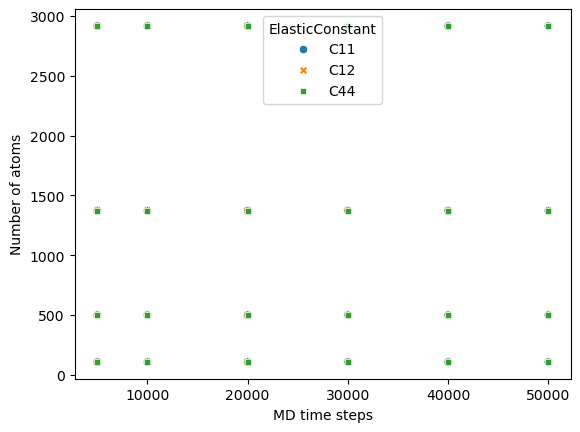

In [33]:
import seaborn as sns

sns.scatterplot(
    data=calculations_df_long,
    x='run',
    y='natoms_output',
    hue='ElasticConstant',  # Differentiates C11, C12, C44
    style='ElasticConstant', # Optional: different styles for each
)
plt.xlabel('MD time steps')
plt.ylabel('Number of atoms')
plt.show()

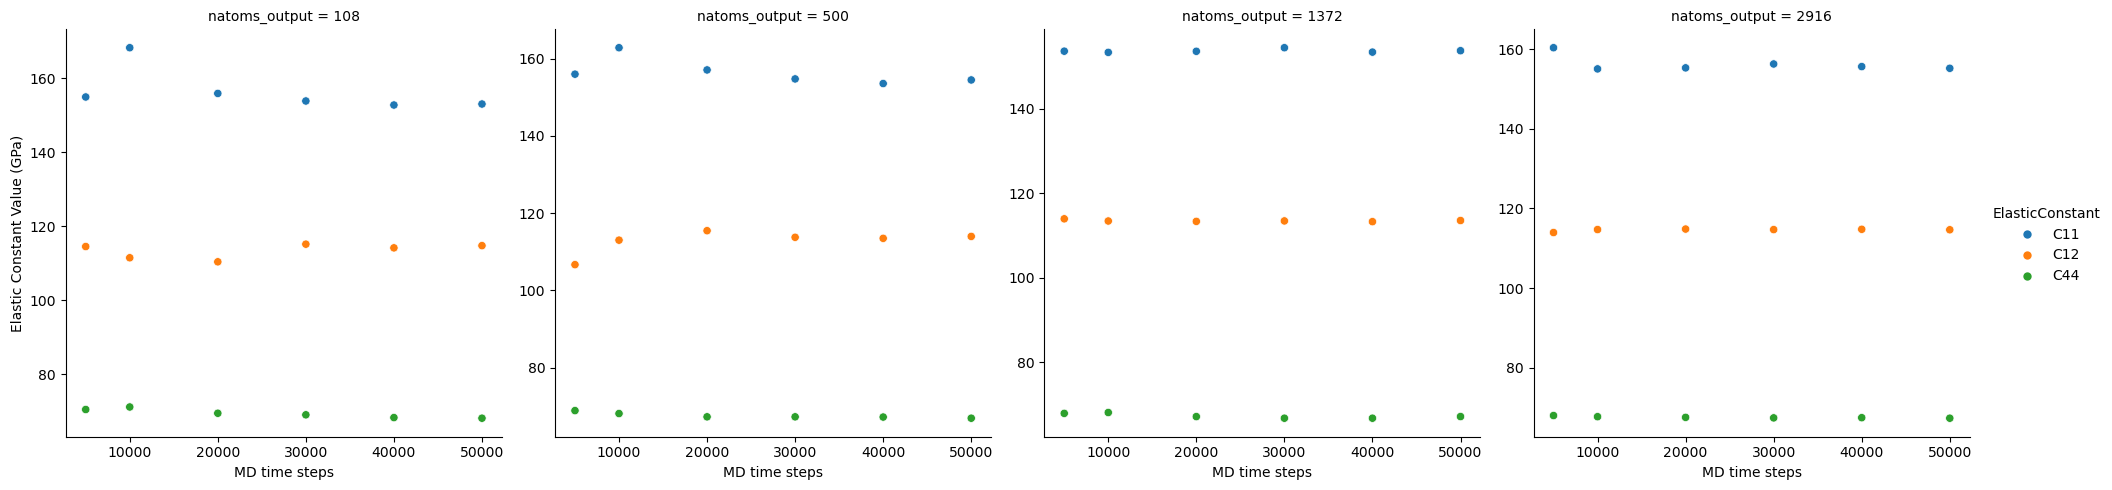

In [34]:
g=sns.relplot(
    data=calculations_df_long,
    x='run',
    y='Value',
    row=None,                # you could use row= instead if you want vertically stacked
    col='natoms_output',     # column facet per unique natoms_output
    hue='ElasticConstant',
    kind='scatter',          # or kind='line' for lines
    facet_kws={'sharey': False, 'sharex': True}
)

g.set_axis_labels("MD time steps", "Elastic Constant Value (GPa)")
plt.show()

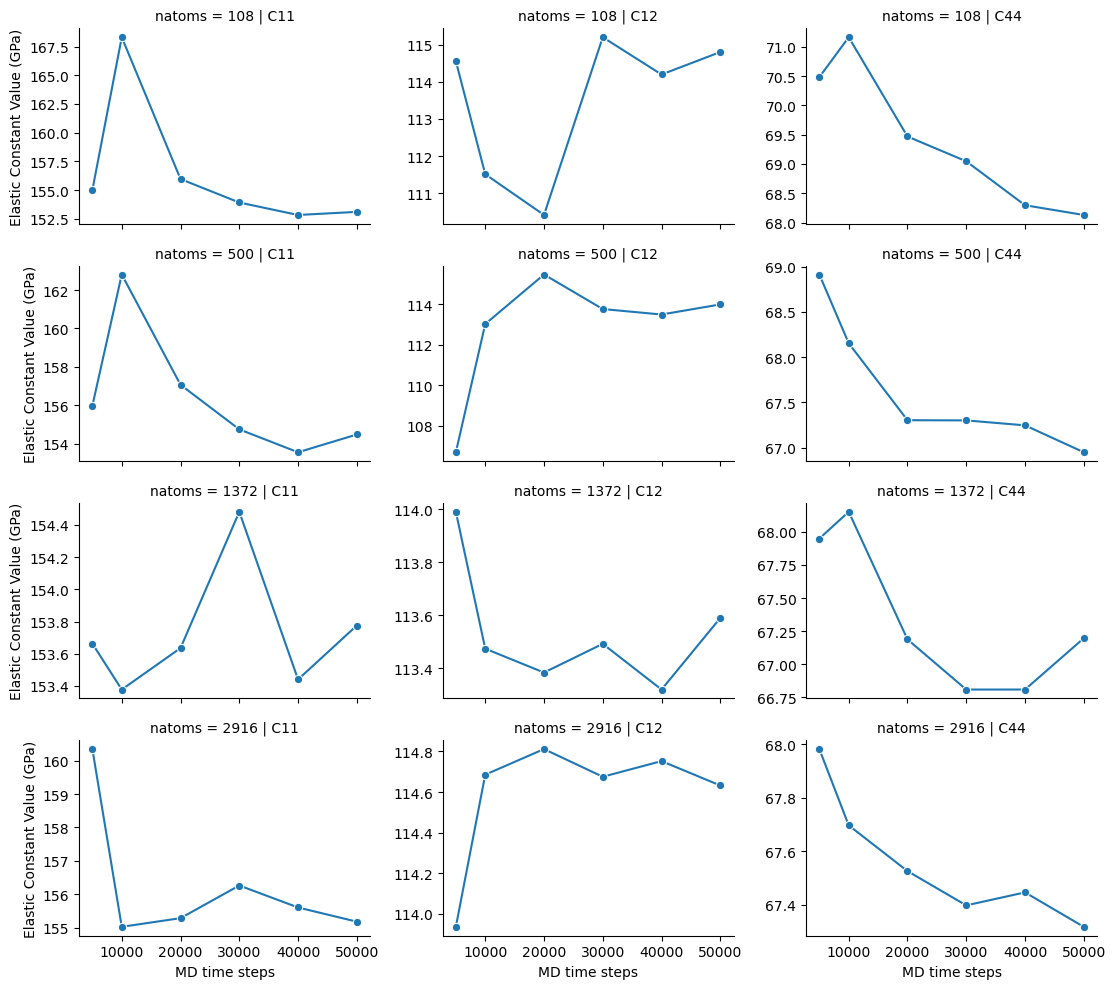

In [35]:
g= sns.relplot(
    data=calculations_df_long,
    x='run',
    y='Value',
    row='natoms_output',
    col='ElasticConstant',
    kind='line',          # Use 'line' if you want line plots
    marker='o',
    facet_kws={'sharey': False, 'sharex': True},
    height=2.5,
    aspect=1.5
)

g.set_axis_labels("MD time steps", "Elastic Constant Value (GPa)")
g.set_titles(row_template='natoms = {row_name}', col_template='{col_name}')
plt.show()

### Number of atoms on x-axis

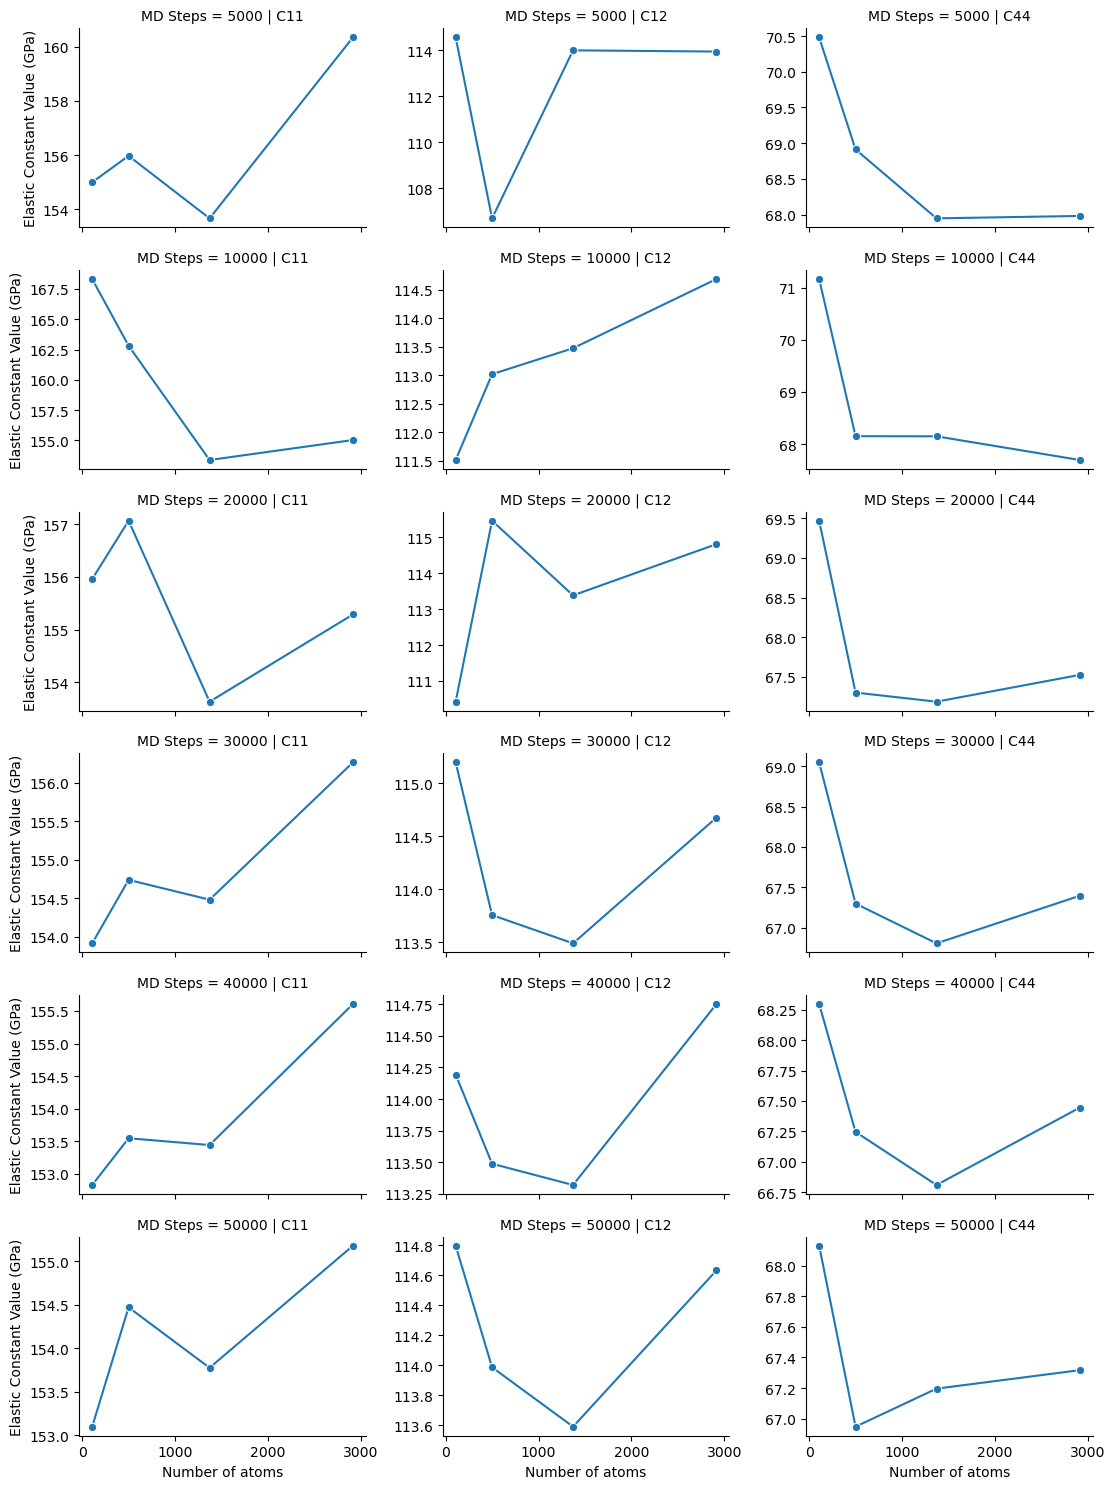

In [36]:
g= sns.relplot(
    data=calculations_df_long,
    x='natoms_output',
    y='Value',
    row='run',
    col='ElasticConstant',
    kind='line',          # Use 'line' if you want line plots
    marker='o',
    facet_kws={'sharey': False, 'sharex': True},
    height=2.5,
    aspect=1.5
)

g.set_axis_labels("Number of atoms", "Elastic Constant Value (GPa)")
g.set_titles(row_template='MD Steps = {row_name}', col_template='{col_name}')
plt.show()